In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
training_set, set_info = tfds.load(name = 'malaria', shuffle_files=True, split='train[:80%]', with_info=True)
testing_set = tfds.load(name = 'malaria', shuffle_files=True, split='train[-20%:]')

In [ ]:
#hyper parameter
batch_size = 64
#image size squared
image_size = 125
#buffer size
buffer_size = 1000
#number of epochs to train
num_epochs = 25
#learning rate for weight adjustment
learning_rate = 0.0001


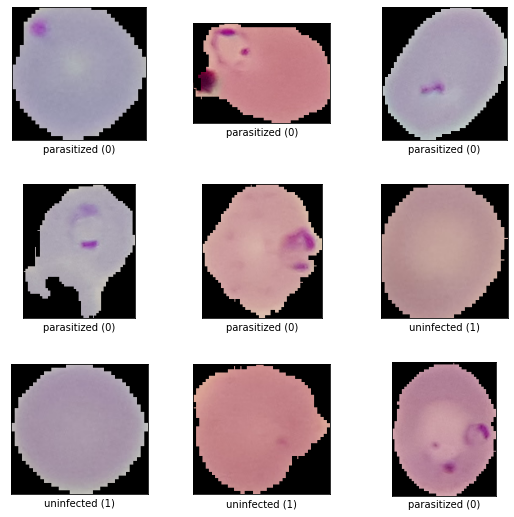

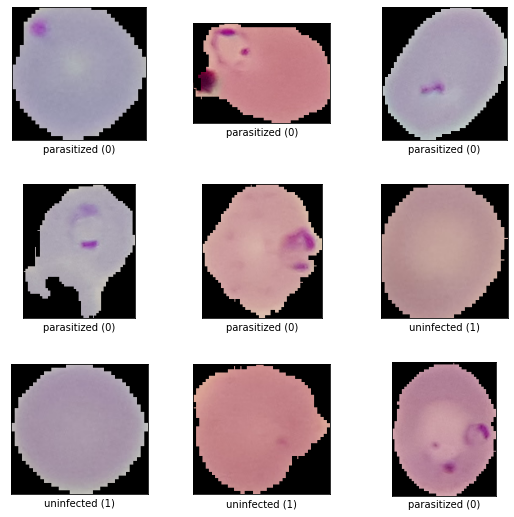

In [ ]:
visualizer = tfds.visualization.ImageGridVisualizer()
visualizer.show(ds= training_set, ds_info= set_info, rows=3, cols=3, plot_scale=3.0)


In [ ]:
averages = []
for sample in training_set:
  averages.append(np.mean(sample['image'].numpy()))
pixel_mean = np.mean(averages)
print(pixel_mean)

119.5211123965262


In [ ]:
def normalize_image(element):
  #normalize auf [-1,1] z values
  element['image'] = (tf.image.resize(element['image'], (image_size, image_size),) - pixel_mean)/pixel_mean
#  element['image'] = (tf.image.resize(element['image'], (image_size, image_size),) - 128)/128
  # try without one_hot encoding
  element['label'] = tf.one_hot(element['label'], 2)
  return element

In [ ]:
#shuffling
# reduce buffer size
training_set = training_set.shuffle(buffer_size)
testing_set = testing_set.shuffle(buffer_size)
#normalize
#onehot encode the labels
train_ds = training_set.map(normalize_image)
test_ds = testing_set.map(normalize_image)
#batching
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)
#prefetch 10
train_ds = train_ds.prefetch(10)
test_ds = test_ds.prefetch(10)


In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer


class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.conv_layer_1 = tf.keras.layers.Conv2D(filters=32,
                                                     kernel_size= 5,
                                                     strides= (1,1),
                                                     padding= 'same',
                                                     input_shape = (batch_size, image_size, image_size, 3),
                                                     activation=tf.keras.activations.relu
                                                    )
                                                    
        self.pool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                        strides=(2,2),
                                                        padding='same'
                                                       )
        
        self.conv_layer_2 = tf.keras.layers.Conv2D(filters=64,
                                                     kernel_size= 3,
                                                     strides= (1,1),
                                                     padding= 'same',
                                                     activation=tf.keras.activations.relu
                                                    )
        
        self.pool_layer_2 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                        strides=(2,2),
                                                        padding='same'
                                                       )
        
        self.conv_layer_3 = tf.keras.layers.Conv2D(filters=64,
                                                     kernel_size= 2,
                                                     strides= (1,1),
                                                     padding= 'same',
                                                     activation=tf.keras.activations.relu
                                                    )
        
        self.pool_layer_3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                        strides=(2,2),
                                                        padding='same'
                                                       )
        
        self.conv_layer_4 = tf.keras.layers.Conv2D(filters=128,
                                                     kernel_size= 2,
                                                     strides= (1,1),
                                                     padding= 'same',
                                                     activation=tf.keras.activations.relu
                                                    )
        
        self.pool_layer_4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),
                                                        strides=(2,2),
                                                        padding='same'
                                                       )

        self.flatten_layer_1 = tf.keras.layers.Flatten()

        self.dense_layer_1 = tf.keras.layers.Dense(units=512,
                                                    activation=tf.keras.activations.relu)
        
        self.drop_layer_1 = tf.keras.layers.Dropout(0.3)


        self.output_layer = tf.keras.layers.Dense(units=2,
                                                  activation= tf.keras.activations.sigmoid)
               
    def call(self, x):
        # Define the forward step.
        x = self.conv_layer_1(x)
        x = self.pool_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.pool_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.pool_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.pool_layer_4(x)
        x = self.flatten_layer_1(x)
        x = self.dense_layer_1(x)
        x = self.drop_layer_1(x)
        x = self.output_layer(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for example in test_data:
    input = example['image']
    target = example['label']
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  


In [ ]:
tf.keras.backend.clear_session()

#learning rate schedule to decay the learning rate over the training process to reduce overfitting
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=len(train_ds),
  decay_rate=1,
  staircase=False)

### Hyperparameters
running_average_factor = 0.95

# Initialize the model.
model = Model()


# Initialize the loss: Binary cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(lr_schedule)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, train_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))


    #training (and checking in with training)
    running_average = 0
    for example in train_ds:
      input = example["image"]
      target = example["label"]
      train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
      running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Epoch: __ 10
Epoch: __ 11
Epoch: __ 12
Epoch: __ 13
Epoch: __ 14
Epoch: __ 15
Epoch: __ 16
Epoch: __ 17
Epoch: __ 18
Epoch: __ 19
Epoch: __ 20
Epoch: __ 21
Epoch: __ 22
Epoch: __ 23
Epoch: __ 24


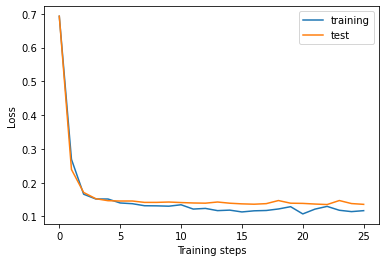

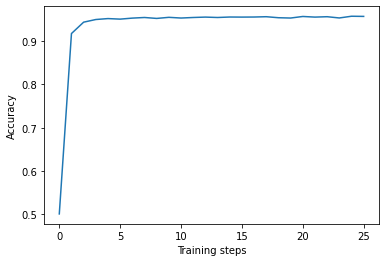

0.9567169540229885


In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
print(test_accuracies[-1])
